# Boston BLUEbikes - EDA and Predicting Hourly Demand 
---------------------------------------------------------------------------------------------------------------

##  Table of Contents:

## I.    [Introduction](#I)
## II.   [Data Exploration](#DE)
* Libraries and Data Imports  
* Quick Views of BLUEbikes Data 
* Handling NA / Missing Values
* Unique Stations
* Breaking down rides on month, day of week, hour

## III.  [Data Visualization](#DV)
* Visualizing metrics across Month, Day of Week and Hour of Day
* Looking at Average Tripduration per Start-End pair
* Looking at Count of Trips per Start-End pair
* Focusing on one Start-End Pair to observe distribution of tripduration
* Distribution of start and end stations
* Aggregating bike pickups by zone, date, and hour
* Filling in missing dates with sample index
* Visualizing Pickup Timeseries Data


## IV.   [Data Preparation](#DP)
* Adding 48-hours of Lags
* Splitting Data into Train, Val, Test - X and y
* Scaling Data


## V.    [Model](#M)
* Model and Data Setup
* Model Parameters
* Tensorflow Network and Tensors Setup
* Training Model
* Evaluating Model Performance
* Exporting Session Model Variables
* Evaluating Results and Next Steps

---------------------------------------------------------------------------------------------------------------

## I. <a id='I'>Introduction</a>
Boston BLUEbikes (formerly Hubway) is the Greater Boston Area's bike share network. In this notebook, trip information data is visualized, analyzed, and modeled to predict hourly demand across the network. To predict demand, a Long Short Term Memory Recurrent Neural Network (RNN) was implemented with Tensorflow to input the previous 48 hours of pickup data and predict the next hour's pickup demand. The code in this notebook provides step-by-step explanations and visualizations where necessary, and commented information to understand Tensorflow model, and input and output shapes.

__Data Sources__:
* Trip information data is provided by <a href="https://www.bluebikes.com/system-data" target="_blank">BLUEbikes</a>. BLUEbikes provides data on trips by month found <a href="https://s3.amazonaws.com/hubway-data/index.html" target="_blank">here</a>.
    * Data downloaded covers BLUEbikes trip data from the months of __January 2015__ through __September 2017__.

## II. <a id='DE'>Data Exploration</a>

#### Libraries and Data Imports

In [1]:
import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
%matplotlib inline

In [2]:
csv_path = '../data/data_2015_2017_9.csv'

bluebikes_data = pd.read_csv(csv_path)

#### Quick Views of BLUEbikes Data

In [3]:
bluebikes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3348338 entries, 0 to 3348337
Data columns (total 15 columns):
tripduration               int64
starttime                  object
stoptime                   object
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             object
end station name           object
end station latitude       object
end station longitude      object
bikeid                     int64
usertype                   object
birth year                 object
gender                     int64
dtypes: float64(2), int64(4), object(9)
memory usage: 383.2+ MB


From BLUEbikes website:
* __tripduration__ in seconds
* __usertype__ (Casual = Single Trip or Day Pass user; Member = Annual or Monthly Member) 
    * Cell below shows two classes: 'Subscriber' and 'Customer'
* No indication of what __gender__ values mean 

Looking at NULL values in dataset:

In [4]:
bluebikes_data.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

Gender values:

In [5]:
bluebikes_data.gender.unique()

array([1, 2, 0])

Usertype values:

In [6]:
bluebikes_data.usertype.unique()

array(['Subscriber', 'Customer'], dtype=object)

In [7]:
bluebikes_data.tripduration.max() # seconds

29906079

In [8]:
bluebikes_data.iloc[bluebikes_data.tripduration.argmax()]

tripduration                                                  29906079
starttime                                     2016-12-25 07:30:38.5390
stoptime                                      2017-12-06 10:45:17.9620
start station id                                                    36
start station name         Copley Square - Dartmouth St at Boylston St
start station latitude                                         42.3499
start station longitude                                       -71.0774
end station id                                                      26
end station name                           Washington St at Waltham St
end station latitude                                           42.3415
end station longitude                                         -71.0689
bikeid                                                            1053
usertype                                                      Customer
birth year                                                        1969
gender

Longest BLUEbikes Trip: __almost 1 year__... error or lost bike?

In [9]:
bluebikes_data['tripduration'] = bluebikes_data.tripduration / 60 # seconds/minute

#### Handling NA / Missing Values

NaNs in this dataset are filled with '\\N' instead of NaN. Filling with NaNs to handle them.

In [10]:
bluebikes_data = bluebikes_data.replace(r'\\N', float('NaN'), regex=True) 

In [11]:
bluebikes_data.isnull().sum()

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  1
end station name                1
end station latitude            1
end station longitude           1
bikeid                          0
usertype                        0
birth year                 648016
gender                          0
dtype: int64

#### Analysis won't look at birth year, so those NaNs will be ignored. Just removing __end station id__ NaN.

In [12]:
bluebikes_data = bluebikes_data[bluebikes_data['end station id'].notnull()]

In [13]:
bluebikes_data['end station id'] = bluebikes_data['end station id'].astype(int)

In [14]:
bluebikes_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,9.033333,2015-01-01 00:21:44,2015-01-01 00:30:47,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,Subscriber,1984,1
1,7.300000,2015-01-01 00:27:03,2015-01-01 00:34:21,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,648,Subscriber,1985,1
2,4.233333,2015-01-01 00:31:31,2015-01-01 00:35:46,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,68,Central Square at Mass Ave / Essex St,42.36507,-71.1031,555,Subscriber,1974,1
3,7.200000,2015-01-01 00:53:46,2015-01-01 01:00:58,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1307,Subscriber,1987,1
4,12.250000,2015-01-01 01:07:06,2015-01-01 01:19:21,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,177,Customer,1986,2


#### Unique Stations

In [15]:
grouped = bluebikes_data.drop_duplicates('start station name')

In [16]:
grouped = grouped[
    ['start station id', 'start station name']].sort_values(by='start station id')

In [17]:
grouped.head(10)

,start station id,start station name
16963,1,18 Dorrance Warehouse
34209,3,Colleges of the Fenway
2314231,3,Colleges of the Fenway - Fenway at Avenue Loui...
2313792,4,Tremont St at E Berkeley St
34116,4,Tremont St. at Berkeley St.
2314013,5,Northeastern University - North Parking Lot
34727,5,Northeastern U / North Parking Lot
2313790,6,Cambridge St at Joy St
34101,6,Cambridge St. at Joy St.
34593,7,Fan Pier


Looks like some station ids have 2 slightly different names. 

#### Breaking down rides on month, day of week, hour

In [18]:
bluebikes_data['starttime'] = pd.to_datetime(bluebikes_data.starttime)
bluebikes_data['stoptime'] = pd.to_datetime(bluebikes_data.stoptime)

In [19]:
bluebikes_data['Month'] = bluebikes_data.starttime.dt.month
bluebikes_data['Year'] = bluebikes_data.starttime.dt.year
bluebikes_data['Day'] = bluebikes_data.starttime.dt.day
bluebikes_data['Weekday'] = bluebikes_data.starttime.dt.weekday_name
bluebikes_data['Hour'] = bluebikes_data.starttime.dt.hour

## III. <a id='DV'>Data Visualization</a>

#### Visualizing metrics across Month, Day of Week and Hour of Day

Text(0.5, 1.0, 'Average BLUEbikes Trip Duration per Hour of Day')

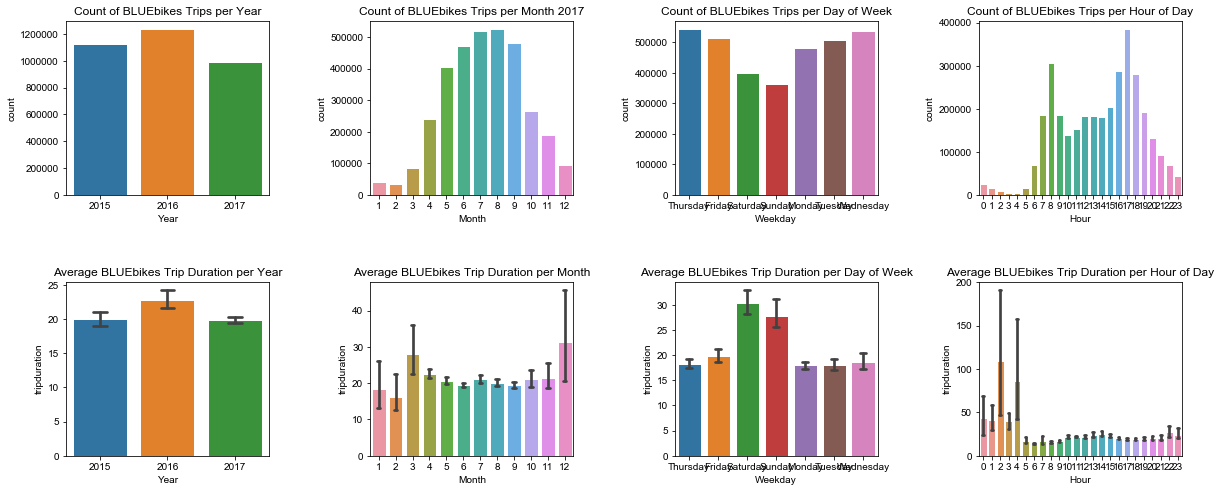

In [20]:
f, axes = plt.subplots(2, 4, figsize=(20,8))
plt.subplots_adjust(wspace=.5, hspace=.5)

sns.set_style('darkgrid')
sns.axes_style('darkgrid')

measure = bluebikes_data.tripduration

# plots 1-4: counts
sns.countplot(x='Year', data=bluebikes_data, ax=axes[0,0]) \
            .set_title("Count of BLUEbikes Trips per Year")

sns.countplot(x='Month', data=bluebikes_data, ax=axes[0,1]) \
            .set_title("Count of BLUEbikes Trips per Month 2017")
    
sns.countplot(x='Weekday', data=bluebikes_data, ax=axes[0,2]) \
            .set_title("Count of BLUEbikes Trips per Day of Week")
    
sns.countplot(x='Hour', data=bluebikes_data, ax=axes[0,3]) \
            .set_title("Count of BLUEbikes Trips per Hour of Day")


# plots 5-8: means
sns.barplot(x=bluebikes_data.Year, y=measure, estimator=np.mean, capsize=.2, ax=axes[1,0]) \
            .set_title("Average BLUEbikes Trip Duration per Year")

sns.barplot(x=bluebikes_data.Month, y=measure, estimator=np.mean, capsize=.2, ax=axes[1,1]) \
            .set_title("Average BLUEbikes Trip Duration per Month")
    
sns.barplot(x=bluebikes_data.Weekday, y=measure, estimator=np.mean, capsize=.2, ax=axes[1,2]) \
            .set_title("Average BLUEbikes Trip Duration per Day of Week")
    
sns.barplot(x=bluebikes_data.Hour, y=measure, estimator=np.mean, capsize=.2, ax=axes[1,3]) \
            .set_title("Average BLUEbikes Trip Duration per Hour of Day")

### Looking at Average Tripduration per Start-End pair

In [21]:
avg_tripdurations = bluebikes_data.tripduration.groupby(
    [
        bluebikes_data['start station id'].rename('start'), 
        bluebikes_data['start station name'].rename('start_name'),
        bluebikes_data['end station id'].rename('end'),
        bluebikes_data['end station name'].rename('end_name')
    ]).agg({'avg_tripduration': 'mean'})

avg_tripdurations = avg_tripdurations.reset_index()
avg_tripdurations['avg_tripduration'] = avg_tripdurations.avg_tripduration.round(2)


avg_tripdurations.sort_values(by='avg_tripduration', ascending=False).head()

,start,start_name,end,end_name,avg_tripduration
38630,173,Savin Hill T Stop - S Sydney St at Bay St,1,18 Dorrance Warehouse,179106.25
1571,8,Union Square - Brighton Ave at Cambridge St,1,18 Dorrance Warehouse,128578.83
4548,19,Buswell St. at Park Dr.,1,18 Dorrance Warehouse,122491.08
21898,81,Boylston St / Washington St,1,18 Dorrance Warehouse,96455.98
16859,60,Charles Circle - Charles St. at Cambridge St.,1,18 Dorrance Warehouse,93320.08


Seems like all the longest trips are to __18 Dorrance Warehouse__. Possibly a service warehouse for the bikes? If so, there may be some process to collect bikes and check them in to warehouse that explains long tripdurations.

#### Looking at Count of Trips per Start-End pair

In [22]:
count_trips = bluebikes_data.starttime.groupby(
    [
        bluebikes_data['start station id'].rename('start'),
        bluebikes_data['start station name'].rename('start_name'),
        bluebikes_data['end station id'].rename('end'),
        bluebikes_data['end station name'].rename('end_name')
    ]).agg({'count'})

count_trips = count_trips.reset_index()

count_trips.sort_values(by='count', ascending=False).head()

,start,start_name,end,end_name,count
29845,118,Linear Park - Mass. Ave. at Cameron Ave.,100,Davis Square,7498
26251,100,Davis Square,118,Linear Park - Mass. Ave. at Cameron Ave.,7038
39886,179,MIT Vassar St,80,MIT Stata Center at Vassar St / Main St,6779
18702,67,MIT at Mass Ave / Amherst St,179,MIT Vassar St,5909
29005,114,Teele Square at 239 Holland St,100,Davis Square,5441


#### Focusing on one Start-End Pair to observe distribution of tripduration

In [23]:
onetrip_data = bluebikes_data[bluebikes_data['start station id'] == 53]
onetrip_data = onetrip_data[onetrip_data['end station id'] == 67]

Text(0.5, 1.0, 'Distribution of Trip Durations From: \nBeacon St. @ Mass Ave - \nMass Ave. @ MIT / Amherst St')

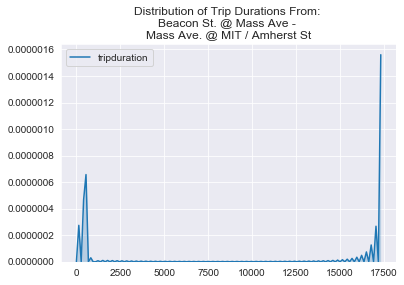

In [24]:
sns.kdeplot(onetrip_data.tripduration, shade=True)\
    .set_title("Distribution of Trip Durations From: \nBeacon St. @ Mass Ave - \nMass Ave. @ MIT / Amherst St")
    
# plt.xlim(0, 500)

Text(0.5, 1.0, 'Boxplot of All Trip Durations')

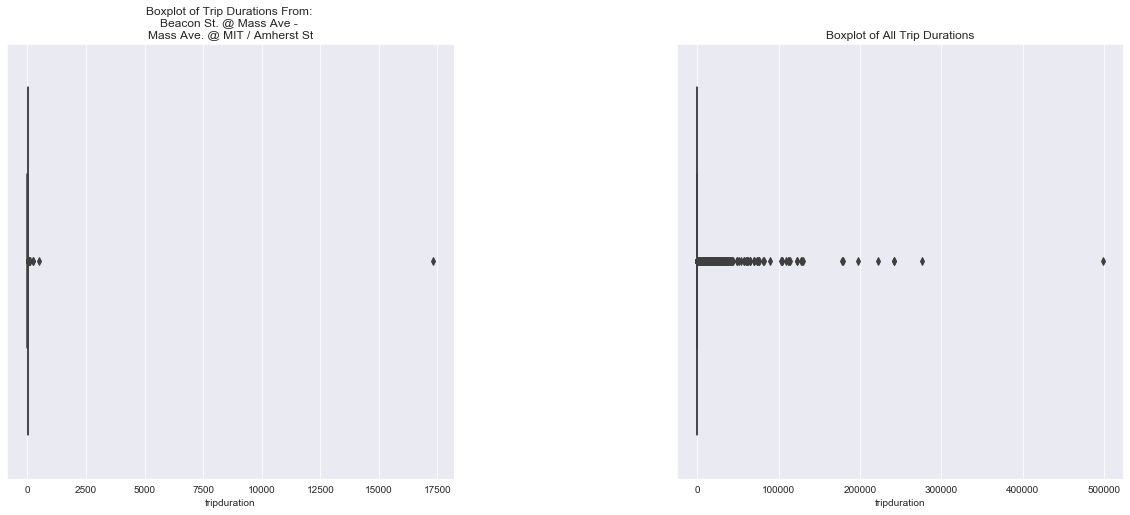

In [25]:
f, axes = plt.subplots(1, 2, figsize=(20,8))
plt.subplots_adjust(wspace=.5, hspace=.5)

sns.boxplot(x=onetrip_data['tripduration'], ax=axes[0]) \
    .set_title("Boxplot of Trip Durations From: \nBeacon St. @ Mass Ave - \nMass Ave. @ MIT / Amherst St")

sns.boxplot(x=bluebikes_data['tripduration'], ax=axes[1]) \
    .set_title("Boxplot of All Trip Durations")

#### Distribution of start and end stations

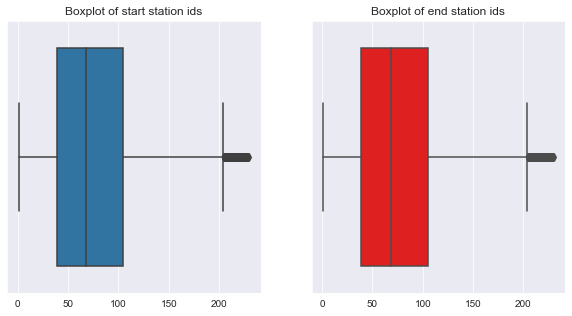

In [26]:
f, axes = plt.subplots(1, 2, figsize=(10,5))

ax = sns.boxplot(x=bluebikes_data[['start station id']], orient='h', ax=axes[0]) \
    .set_title("Boxplot of start station ids")

ax = sns.boxplot(x=bluebikes_data[['end station id']], orient='h', ax=axes[1], color='red') \
    .set_title("Boxplot of end station ids")

#### Aggregating bike pickups by zone, date, and hour

In [27]:
bluebikes_data['datetime'] = bluebikes_data.starttime.dt.floor('h')

In [28]:
pickup_data = bluebikes_data.datetime.groupby(
    [
        bluebikes_data.datetime
    ]
).agg({'pickups_count': 'count'})


pickup_data.sort_index(axis=0).head(10)

,pickups_count
datetime,
2015-01-01 00:00:00,4
2015-01-01 01:00:00,3
2015-01-01 02:00:00,1
2015-01-01 04:00:00,1
2015-01-01 08:00:00,4
2015-01-01 09:00:00,2
2015-01-01 10:00:00,8
2015-01-01 11:00:00,6
2015-01-01 12:00:00,11


In [29]:
pickup_data.shape

(23080, 1)

#### Filling in missing dates with sample index

In [30]:
latest_date = str((bluebikes_data.starttime.max() + timedelta(days=1)).date())

In [31]:
dates = pd.date_range(
    '2015-01-01',
    latest_date, 
    freq="1H", 
    closed='left'
)

dates

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2017-09-30 14:00:00', '2017-09-30 15:00:00',
               '2017-09-30 16:00:00', '2017-09-30 17:00:00',
               '2017-09-30 18:00:00', '2017-09-30 19:00:00',
               '2017-09-30 20:00:00', '2017-09-30 21:00:00',
               '2017-09-30 22:00:00', '2017-09-30 23:00:00'],
              dtype='datetime64[ns]', length=24096, freq='H')

In [32]:
dates.shape

(24096,)

In [33]:
dates = list(dates)

In [34]:
pickup_data = pickup_data.reindex(dates)

In [35]:
pickup_data = pickup_data.fillna(0)

In [36]:
pickup_data.head(5)

,pickups_count
datetime,
2015-01-01 00:00:00,4.0
2015-01-01 01:00:00,3.0
2015-01-01 02:00:00,1.0
2015-01-01 03:00:00,0.0
2015-01-01 04:00:00,1.0


In [37]:
pickup_data.shape

(24096, 1)

#### Visualizing Pickup Timeseries Data

Text(0.5, 1.0, 'BLUEbikes Pickup Counts in 2017')

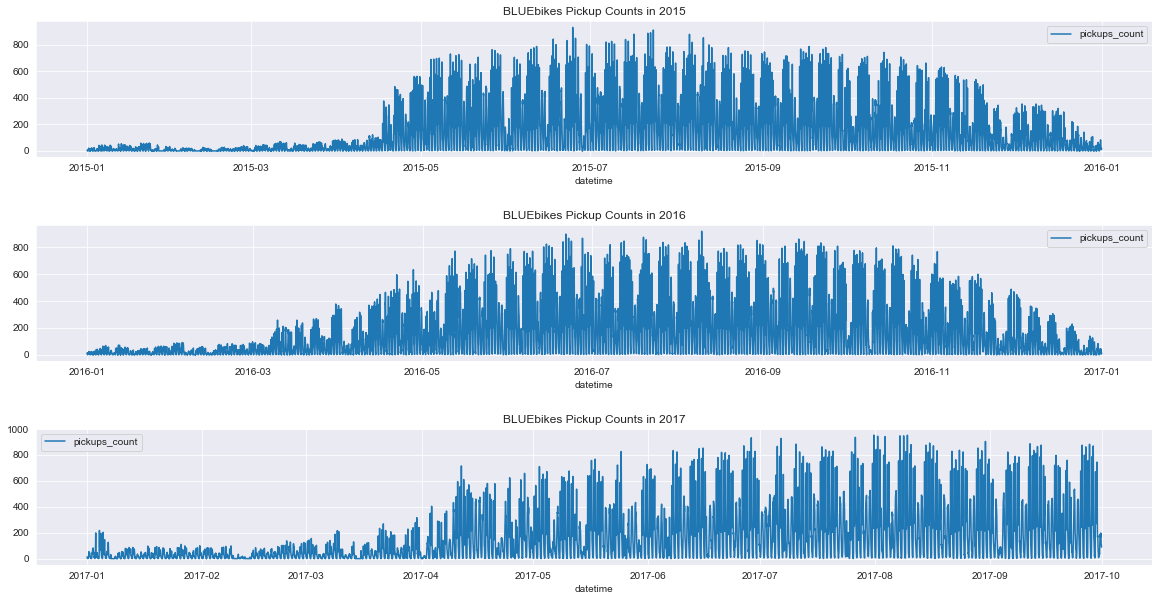

In [38]:
f, axes = plt.subplots(3, 1, figsize=(20,10))
plt.subplots_adjust(wspace=.5, hspace=.5)

sns.axes_style("darkgrid")

sns.lineplot(data=pickup_data.loc['2015-01-01':'2015-12-31'], ax=axes[0]) \
            .set_title("BLUEbikes Pickup Counts in 2015")

sns.lineplot(data=pickup_data.loc['2016-01-01':'2016-12-31'], ax=axes[1]) \
            .set_title("BLUEbikes Pickup Counts in 2016")

sns.lineplot(data=pickup_data.loc['2017-01-01':'2017-12-31'], ax=axes[2]) \
            .set_title("BLUEbikes Pickup Counts in 2017")

# sns.lineplot(data=pickup_data.loc['2018-01-01':'2018-12-31'], ax=axes[3]) \
#             .set_title("BLUEbikes Pickup Counts in 2018")

Text(0.5, 1.0, 'BLUEbikes Pickup Counts: July 2017')

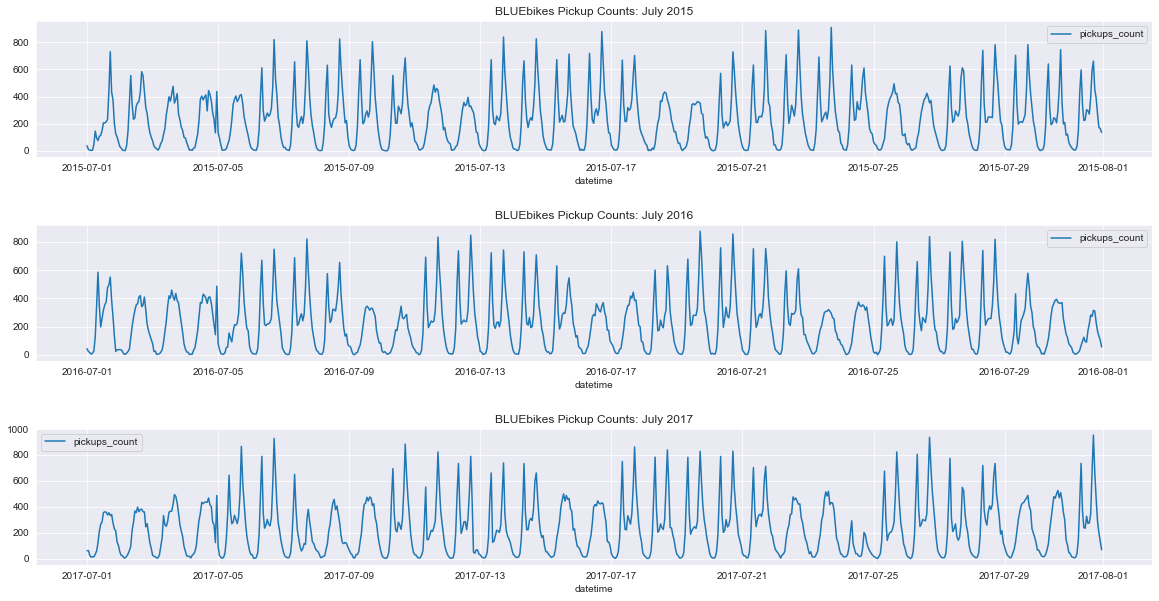

In [39]:
f, axes = plt.subplots(3, 1, figsize=(20,10))
plt.subplots_adjust(wspace=.5, hspace=.5)

sns.lineplot(data=pickup_data.loc['2015-07-01':'2015-07-31'], ax=axes[0]) \
            .set_title("BLUEbikes Pickup Counts: July 2015")

sns.lineplot(data=pickup_data.loc['2016-07-01':'2016-07-31'], ax=axes[1]) \
            .set_title("BLUEbikes Pickup Counts: July 2016")

sns.lineplot(data=pickup_data.loc['2017-07-01':'2017-07-31'], ax=axes[2]) \
            .set_title("BLUEbikes Pickup Counts: July 2017")

# sns.lineplot(data=pickup_data.loc['2018-07-01':'2018-07-31'], ax=axes[3]) \
#             .set_title("BLUEbikes Pickup Counts: July 2018")

In [40]:
print('Max Hourly Pickups:\n2015: {}\n2016: {}\n2017: {}\n'.format(
    pickup_data.loc['2015-01-01':'2015-12-31'].max().values,
    pickup_data.loc['2016-01-01':'2016-12-31'].max().values,
    pickup_data.loc['2017-01-01':'2017-12-31'].max().values
    # pickup_data.loc['2018-01-01':'2018-12-31'].max().values
    )
)

Max Hourly Pickups:
2015: [929.]
2016: [920.]
2017: [953.]



From the graphs above, there is a clearly apparent daily, weekly, and yearly trend. At the weekly seasonal level, there are 5 periods with two spikes in demand, which may correspond to the __'Count of Bluebikes Trips per Hour of Day'__ graph above, where there is a morning and evening peak. 

Also there are two smaller, more parabolic peak activity periods in between which may correspond to Saturday and Sunday demand, from looking at the __'Count of Bluebikes Trips per Day of Week'__ graph above. Also, these data points are  only from July, so there may be different patterns elsewhere in various seasonal windows.

Hopefully the LSTM model can remember these patterns as it predicts future demand.

## IV. <a id='DP'>Data Preparation</a>

To create our model data, __pickups_count__ in pickup data will be the target output of our input window. To get our input window, the previous 24 hours of pickups_count will precede our target output. The code below sets up that structure.

In [41]:
pickup_data.head(5)

,pickups_count
datetime,
2015-01-01 00:00:00,4.0
2015-01-01 01:00:00,3.0
2015-01-01 02:00:00,1.0
2015-01-01 03:00:00,0.0
2015-01-01 04:00:00,1.0


#### Adding 24-hours of Lags

In [42]:
def get_lag_features(lag_step, unit, n):
    '''
    lag_step: number of hours to shift by for each feature n
    unit: 'hour', 'day', 'week', etc. 
    n: number of shift columns/features to create
    '''
    for i in range(1, n+1):
        
        col_name = unit + str(i) + '_lag_count' # ex: 'week1_lag_count'
        
        shift = i * lag_step
        
        pickup_data[col_name] = pickup_data['pickups_count'].shift(shift)

In [43]:
get_lag_features(1, 'hour', 48) # Creates 24 1 hour lags on pickups_count
pickup_data.dropna(inplace=True) # Drop windows with NaN

In [44]:
print(pickup_data.shape)
pickup_data = pickup_data.iloc[:, ::-1] # Reversal of column order
pickup_data.head(5)

(24048, 49)


,hour48_lag_count,hour47_lag_count,hour46_lag_count,hour45_lag_count,hour44_lag_count,hour43_lag_count,hour42_lag_count,hour41_lag_count,hour40_lag_count,hour39_lag_count,hour38_lag_count,hour37_lag_count,hour36_lag_count,hour35_lag_count,hour34_lag_count,hour33_lag_count,hour32_lag_count,hour31_lag_count,hour30_lag_count,hour29_lag_count,hour28_lag_count,hour27_lag_count,hour26_lag_count,hour25_lag_count,hour24_lag_count,hour23_lag_count,hour22_lag_count,hour21_lag_count,hour20_lag_count,hour19_lag_count,hour18_lag_count,hour17_lag_count,hour16_lag_count,hour15_lag_count,hour14_lag_count,hour13_lag_count,hour12_lag_count,hour11_lag_count,hour10_lag_count,hour9_lag_count,hour8_lag_count,hour7_lag_count,hour6_lag_count,hour5_lag_count,hour4_lag_count,hour3_lag_count,hour2_lag_count,hour1_lag_count,pickups_count
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-03 00:00:00,4.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,8.0,6.0,11.0,10.0,21.0,12.0,14.0,9.0,8.0,3.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,14.0,18.0,17.0,10.0,16.0,13.0,19.0,15.0,16.0,22.0,12.0,9.0,12.0,7.0,3.0,1.0,2.0
2015-01-03 01:00:00,3.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,8.0,6.0,11.0,10.0,21.0,12.0,14.0,9.0,8.0,3.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,14.0,18.0,17.0,10.0,16.0,13.0,19.0,15.0,16.0,22.0,12.0,9.0,12.0,7.0,3.0,1.0,2.0,2.0
2015-01-03 02:00:00,1.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,8.0,6.0,11.0,10.0,21.0,12.0,14.0,9.0,8.0,3.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,14.0,18.0,17.0,10.0,16.0,13.0,19.0,15.0,16.0,22.0,12.0,9.0,12.0,7.0,3.0,1.0,2.0,2.0,0.0
2015-01-03 03:00:00,0.0,1.0,0.0,0.0,0.0,4.0,2.0,8.0,6.0,11.0,10.0,21.0,12.0,14.0,9.0,8.0,3.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,14.0,18.0,17.0,10.0,16.0,13.0,19.0,15.0,16.0,22.0,12.0,9.0,12.0,7.0,3.0,1.0,2.0,2.0,0.0,1.0
2015-01-03 04:00:00,1.0,0.0,0.0,0.0,4.0,2.0,8.0,6.0,11.0,10.0,21.0,12.0,14.0,9.0,8.0,3.0,6.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,14.0,18.0,17.0,10.0,16.0,13.0,19.0,15.0,16.0,22.0,12.0,9.0,12.0,7.0,3.0,1.0,2.0,2.0,0.0,1.0,0.0


#### Splitting Data into Train, Val, Test - X and y

In [45]:
train_test_split = 0.85
val_test_split = 0.50

In [46]:
train_idx = math.ceil(len(pickup_data) * train_test_split) # 20462
val_idx = math.ceil(len(pickup_data[train_idx:]) * val_test_split) # 1805

print('Train Indices: 0 - {} ({})\nVal Indices: {} - {} ({})\nTest Indices: {} - {} ({})'.format(
    train_idx - 1, train_idx,
    train_idx, train_idx + val_idx - 1, val_idx,
    train_idx + val_idx, len(pickup_data), len(pickup_data) - (train_idx + val_idx))    
)

Train Indices: 0 - 20440 (20441)
Val Indices: 20441 - 22244 (1804)
Test Indices: 22245 - 24048 (1803)


In [47]:
train_set = pickup_data[:train_idx]
val_set = pickup_data[train_idx:train_idx + val_idx]
test_set = pickup_data[train_idx + val_idx:]

print('Train: {}\nVal: {}\nTest: {}'.format(
    train_set.shape,
    val_set.shape,
    test_set.shape)
)

Train: (20441, 49)
Val: (1804, 49)
Test: (1803, 49)


In [48]:
train_set = train_set.sample(frac=1)

In [49]:
train_set.head(3)

,hour48_lag_count,hour47_lag_count,hour46_lag_count,hour45_lag_count,hour44_lag_count,hour43_lag_count,hour42_lag_count,hour41_lag_count,hour40_lag_count,hour39_lag_count,hour38_lag_count,hour37_lag_count,hour36_lag_count,hour35_lag_count,hour34_lag_count,hour33_lag_count,hour32_lag_count,hour31_lag_count,hour30_lag_count,hour29_lag_count,hour28_lag_count,hour27_lag_count,hour26_lag_count,hour25_lag_count,hour24_lag_count,hour23_lag_count,hour22_lag_count,hour21_lag_count,hour20_lag_count,hour19_lag_count,hour18_lag_count,hour17_lag_count,hour16_lag_count,hour15_lag_count,hour14_lag_count,hour13_lag_count,hour12_lag_count,hour11_lag_count,hour10_lag_count,hour9_lag_count,hour8_lag_count,hour7_lag_count,hour6_lag_count,hour5_lag_count,hour4_lag_count,hour3_lag_count,hour2_lag_count,hour1_lag_count,pickups_count
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-10-13 12:00:00,267.0,261.0,240.0,317.0,519.0,796.0,508.0,258.0,212.0,149.0,99.0,46.0,23.0,16.0,7.0,5.0,2.0,25.0,134.0,383.0,646.0,330.0,198.0,223.0,238.0,240.0,230.0,294.0,471.0,698.0,492.0,278.0,205.0,124.0,83.0,52.0,24.0,22.0,8.0,5.0,6.0,24.0,157.0,445.0,703.0,368.0,219.0,258.0,281.0
2015-03-15 15:00:00,30.0,52.0,62.0,45.0,38.0,19.0,12.0,14.0,7.0,8.0,4.0,3.0,0.0,0.0,0.0,3.0,2.0,1.0,6.0,6.0,5.0,9.0,6.0,5.0,4.0,5.0,6.0,4.0,10.0,6.0,2.0,4.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,14.0,6.0,9.0,21.0,16.0,10.0,11.0
2016-01-31 09:00:00,37.0,22.0,39.0,33.0,40.0,28.0,30.0,50.0,60.0,57.0,33.0,26.0,18.0,11.0,3.0,7.0,4.0,2.0,0.0,1.0,3.0,1.0,1.0,13.0,19.0,24.0,32.0,33.0,50.0,38.0,42.0,34.0,32.0,31.0,21.0,17.0,16.0,3.0,14.0,7.0,5.0,3.0,1.0,0.0,0.0,1.0,3.0,6.0,6.0


In [50]:
def split_X_y(df):
    
    features = df.iloc[:,:-1].values # All rows, all cols except last
    targets = df.iloc[:,-1].values.reshape((len(df), 1)) # All rows, last column, 2d reshape

    return features, targets

In [51]:
train_X, train_y = split_X_y(train_set)
val_X, val_y = split_X_y(val_set)
test_X, test_y = split_X_y(test_set)

In [52]:
print('train_X\n{}\n{}\n\ntrain_y\n{}\n{}'.format(train_X, train_X.shape, train_y, train_y.shape))

train_X
[[267. 261. 240. ... 368. 219. 258.]
 [ 30.  52.  62. ...  21.  16.  10.]
 [ 37.  22.  39. ...   1.   3.   6.]
 ...
 [397. 347. 248. ... 330. 275. 314.]
 [ 36.  98.  73. ...   1.   0.   2.]
 [186. 212. 227. ... 658. 305. 194.]]
(20441, 48)

train_y
[[281.]
 [ 11.]
 [  6.]
 ...
 [387.]
 [  7.]
 [190.]]
(20441, 1)


#### Scaling Data

In [53]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [54]:
train_X_scaled = x_scaler.fit_transform(train_X)

val_X_scaled = x_scaler.transform(val_X)
test_X_scaled = x_scaler.transform(test_X)

In [55]:
train_y_scaled = y_scaler.fit_transform(train_y)

val_y_scaled = y_scaler.transform(val_y)
test_y_scaled = y_scaler.transform(test_y)

In [56]:
print(train_X_scaled)

[[0.28740581 0.28094726 0.2583423  ... 0.39612487 0.23573735 0.27771798]
 [0.03229279 0.05597417 0.06673843 ... 0.02260495 0.01722282 0.01076426]
 [0.03982777 0.02368138 0.04198062 ... 0.00107643 0.00322928 0.00645856]
 ...
 [0.42734123 0.37351991 0.26695371 ... 0.35522067 0.29601722 0.33799785]
 [0.03875135 0.10548977 0.07857912 ... 0.00107643 0.         0.00215285]
 [0.20021529 0.22820237 0.24434876 ... 0.70828848 0.32831001 0.2088267 ]]


## V. <a id='M'>Model</a>

#### Model and Data Setup

In [57]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [68]:
tf.keras.backend.clear_session()

In [60]:
# Expanding dimensions on axis 2 to get 48 x 1 matrices for n_examples
train_X_scaled = np.expand_dims(train_X_scaled, axis=2)
val_X_scaled = np.expand_dims(val_X_scaled, axis=2)
test_X_scaled = np.expand_dims(test_X_scaled, axis=2)

In [61]:
print(train_X_scaled.shape) # 20441 examples of 48 x 1 matrices.
print(val_X_scaled.shape)
print(test_X_scaled.shape)

print(train_y_scaled.shape)
print(val_y_scaled.shape)
print(test_y.shape)

(20441, 48, 1)
(1804, 48, 1)
(1803, 48, 1)
(20441, 1)
(1804, 1)
(1803, 1)


#### Model Parameters

In [62]:
n_hidden_units = 64
batch_size = 128
epochs = 50

#### Tensorflow Model Setup

In [69]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(n_hidden_units, return_sequences=True),
        tf.keras.layers.LSTM(n_hidden_units),
        tf.keras.layers.Dense(1, activation='relu')
    ])

In [70]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

In [71]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                                  monitor='val_loss', 
                                  factor=0.1,
                                  patience=4,
                                  verbose=1,
                                  min_delta=.0001,
                                  min_lr=0.0001,
                                  cooldown=2)

early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    min_delta=0.0001,
                                    patience=5,
                                    verbose=1,
                                    restore_best_weights=False)

In [72]:
model.fit(
    x=train_X_scaled, 
    y=train_y_scaled, 
    epochs=epochs,
    batch_size=batch_size,
    verbose=1, 
    callbacks=[reduce_lr, early_stop],
    validation_data=[val_X_scaled, val_y_scaled], 
    shuffle=False)

Train on 20441 samples, validate on 1804 samples
Epoch 1/50
20441/20441 [==============================] - 74s 4ms/sample - loss: 0.0145 - val_loss: 0.0180
Epoch 2/50
20441/20441 [==============================] - 61s 3ms/sample - loss: 0.0090 - val_loss: 0.0147
Epoch 3/50
20441/20441 [==============================] - 61s 3ms/sample - loss: 0.0068 - val_loss: 0.0118
Epoch 4/50
20441/20441 [==============================] - 61s 3ms/sample - loss: 0.0051 - val_loss: 0.0097
Epoch 5/50
20441/20441 [==============================] - 61s 3ms/sample - loss: 0.0040 - val_loss: 0.0079
Epoch 6/50
20441/20441 [==============================] - 62s 3ms/sample - loss: 0.0032 - val_loss: 0.0068
Epoch 7/50
20441/20441 [==============================] - 62s 3ms/sample - loss: 0.0026 - val_loss: 0.0056
Epoch 8/50
20441/20441 [==============================] - 61s 3ms/sample - loss: 0.0022 - val_loss: 0.0046
Epoch 9/50
20441/20441 [==============================] - 62s 3ms/sample - loss: 0.0020 - val_l

#### Evaluating Model Performance 

In [73]:
y_pred = model.predict(x=test_X_scaled)

In [74]:
model.evaluate(x=test_X_scaled, y=test_y_scaled)

1803/1803 [==============================] - 3s 2ms/sample - loss: 0.0018


0.0018407566219395728

In [75]:
y_pred_unscaled = y_scaler.inverse_transform(y_pred)

In [76]:
y_pred_unscaled

array([[184.83264 ],
       [127.691444],
       [ 82.44749 ],
       ...,
       [ 88.72715 ],
       [ 82.6962  ],
       [ 77.853264]], dtype=float32)

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
scaled_mse = mean_squared_error(y_pred=y_pred, y_true=test_y_scaled)

mse = mean_squared_error(y_pred=y_pred_unscaled, y_true=test_y)
rmse = np.sqrt(mse)

print('Test Set Performance:\n\nScaled MSE:\t{}\nUnscaled MSE:\t{}\nUnscaled RMSE:\t{}'.format(
    scaled_mse, 
    mse,
    rmse)
)

Test Set Performance:

Scaled MSE:	0.0018407565943673427
Unscaled MSE:	1588.6484325875947
Unscaled RMSE:	39.85785283463718


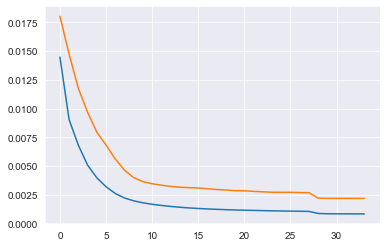

In [79]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [80]:
results = pd.DataFrame(test_y, columns=['y_true'])

results['y_pred'] = y_pred_unscaled

# Adding datetime index to results for graphing x-axis. 
# Slicing dates by the test dates' indices...
results['datetime'] = dates[-(len(test_y)):]
results.set_index('datetime', inplace=True, drop=True)

In [86]:
results.head()

,y_true,y_pred
datetime,,
2017-07-17 21:00:00,185.0,184.832642
2017-07-17 22:00:00,133.0,127.691444
2017-07-17 23:00:00,44.0,82.447487
2017-07-18 00:00:00,25.0,25.064182
2017-07-18 01:00:00,15.0,-0.000000


Text(0.5, 1.0, '(3/3) LSTM Predicted Demand vs. Actual')

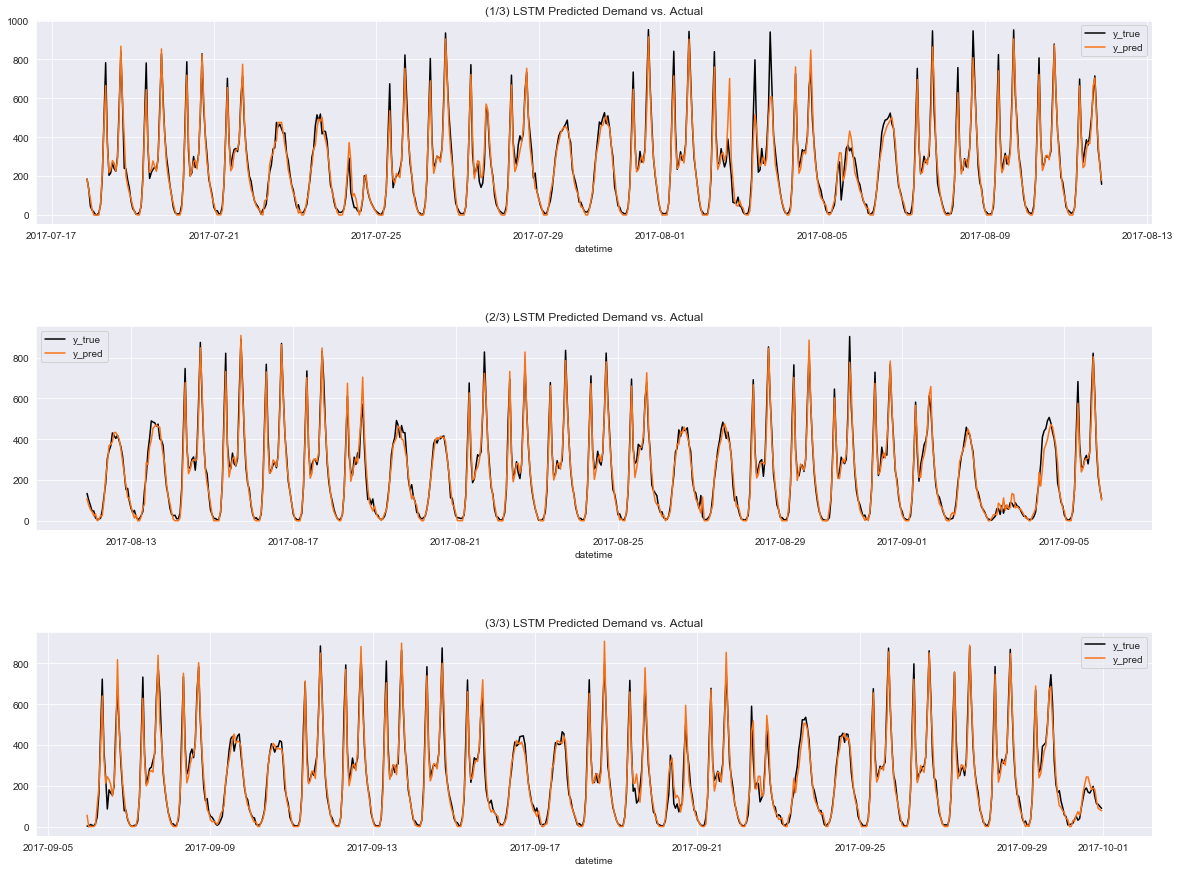

In [82]:
f, axes = plt.subplots(3, 1, figsize=(20,15))

plt.subplots_adjust(wspace=.5, hspace=.5)
idx_split = math.ceil(len(test_y) / 3)
palette = ['#000000', '#F87217']

sns.lineplot(data=results[:idx_split], ax=axes[0], palette=palette, dashes=False) \
            .set_title("(1/3) LSTM Predicted Demand vs. Actual")

sns.lineplot(data=results[idx_split:-idx_split], ax=axes[1], palette=palette, dashes=False) \
            .set_title("(2/3) LSTM Predicted Demand vs. Actual")

sns.lineplot(data=results[-idx_split:], ax=axes[2], palette=palette, dashes=False) \
            .set_title("(3/3) LSTM Predicted Demand vs. Actual")

(0, 911.0609161376954)

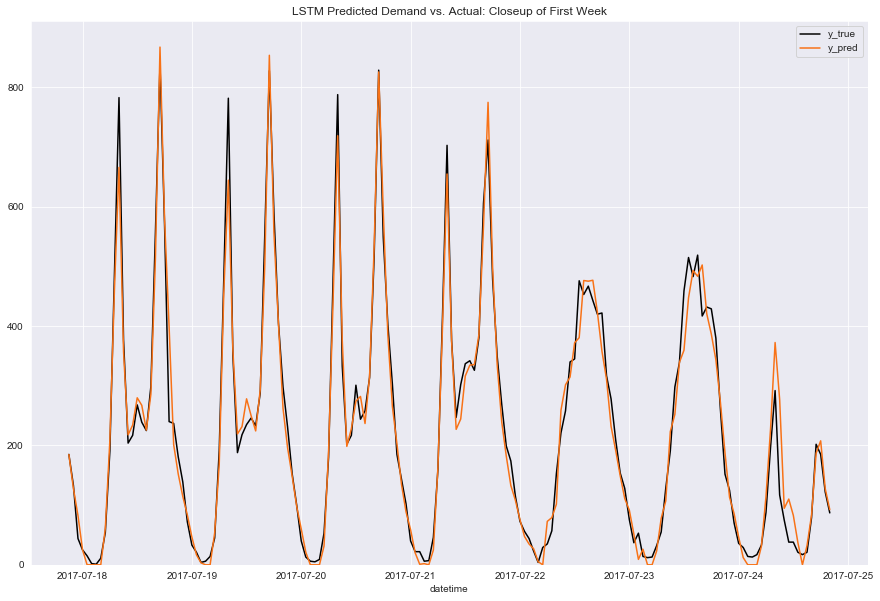

In [83]:
f, axes = plt.subplots(1, 1, figsize=(15,10))

sns.lineplot(data=results[:24*7], ax=axes, palette=palette, dashes=False) \
            .set_title("LSTM Predicted Demand vs. Actual: Closeup of First Week")
plt.ylim(0,)

#### Exporting Session Model Variables

In [84]:
checkpoint_path = '../model-checkpoints/'
model_name = 'trained_lstm_model_2-64'

In [85]:
### Save model:

model.save(checkpoint_path + model_name + '.h5')

#### Evaluating Results and Next Steps

From the graphs above, the LSTM model has picked up some of the daily and weekly seasonal patterns from the training data. However, it often doesn't pick up on some of the daily peaks in demand, or some of the finer intraday noise, and occasionally will overshoot the peak predictions from the ground truth.

Certain things, like more layers, changing the input data size, reducing learning rate on plateau, and other parameter/hyperparameter changes may help to improve predictions and help the network converge on loss faster. 

Additionally, certain metadata and side information such as day of week, time of day, month, weather could be incorporated as inputs and provide more context to the model than just the previous 48 hours of pickup.

For now, this simple implementation of an LSTM model performed well on the testing data and leaves a good starting point for updating and improving the model.